# Advanced Stimulus Options

---

## Contents
1. [Example: Advanced options when using current-clamp stimulation](#example-advance-icalmp)
2. [Example: Using current-clamp with complex and customized waveforms](#example-iclamp-waveforms)
3. [Example: Applying voltage-clamps to cells during simulation](#example-voltage-clamps)
4. [Example: Using sweep data from Allen Cell-Types In-vivo experiments](#example-cell-types)
5. [Example: Stimulating a network with extracellular field potentials](#example-xstim)

---

## Example: Advanced IClamp Options <a class="anchor" id="example-advance-icalmp">

By default you can insert a simple step current into a cell in your simulation by adding corresponding statement to the "inputs" section of your SONATA configuration file. For example, say we want to insert a 0.100 nA injection at t=500 ms for a duration of 1000 ms into the soma of our first cell:

```json
"inputs": {
    "current_clamp": {
        "input_type": "clamp",
        "module": "IClamp",
        "node_set": {
            "population": "net"
            "node_id": 0
        },
        "amp": 0.1000,
        "delay": 500.0,
        "duration": 1000.0,
        "section_name": "soma",
        "section_index": 0,
        "section_dist": 0.5
    }
}
```
* **input_type** and **module** should always be set to values `clamp` and `IClamp`, respecitvely.
* The **node_set** specifies what cell(s) we want to apply to the clamp. In this case only cell with node-id #0 in the "net" population of cells.
* **amp** is the amplitude of the clamp to apply, in nA.
* **delay** and **duration** tells us when to start the clamp and how long to apply it for, both in ms. In this case it will be a current from 500 ms to 1500 ms after start of simulation.
* **section_name**, **section_index**, and **section_dist** tells us exactly where on the cell to place the clamp. In this case at the center of the soma. (*If you leave section_index and section_dist blank BMTK will attempt to find a random available place where to insert the clamp*)
<div class="alert alert-block alert-info">
 NOTE: For PoinNet users section_name, section_index and section_dist are not applicable and can be removed.
</div>


In [5]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.current_clamp.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 10:30:21,328 [INFO] Created log file
2024-05-05 10:30:21,425 [INFO] Building cells.
2024-05-05 10:30:22,432 [INFO] Building recurrent connections
2024-05-05 10:30:22,441 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-05-05 10:30:22,442 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 10:30:22,443 [INFO] Block save every 5000 steps
2024-05-05 10:30:23,460 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 10:30:24,561 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 10:30:25,690 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 10:30:26,812 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 10:30:26,836 [INFO] Simulation completed in 4.394 seconds 


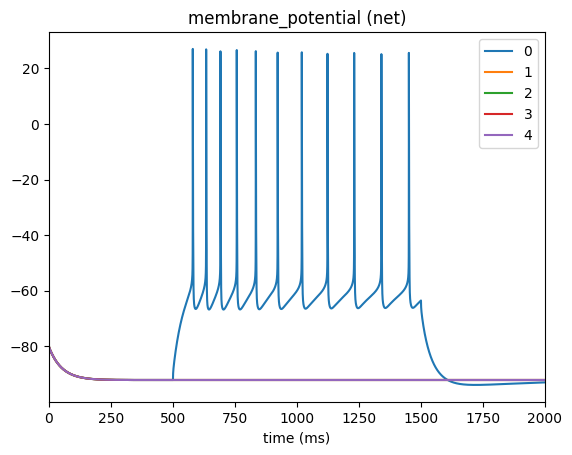

In [9]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.current_clamp.json',  node_ids=range(5), report_name='membrane_potential')

#### Selecting multiple cells

In the above cells #1-4 have a flat trace since we only applied the current to cell #0. If you want to apply the same current to a specific population of cells you can use the **node_set** option to filter according to any available attributes. For example, say we want to apply the current cells in our network that have **model_type=biophysical**:

```json
"current_clamp": {
    "input_type": "current_clamp",
    "module": "IClamp",
    "node_set": {
        "population": "net", 
        "model_type": "biophysical"
    },
    "amp": 0.1000,
    "delay": 500.0,
    "duration": 1000.0,
    "section_name": "soma"
}
```

In [10]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.current_clamp_allcells.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 10:38:22,112 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-05-05 10:38:22,130 [INFO] Building cells.
2024-05-05 10:38:23,128 [INFO] Building recurrent connections
2024-05-05 10:38:23,141 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-05-05 10:38:23,142 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 10:38:23,143 [INFO] Block save every 5000 steps
2024-05-05 10:38:24,566 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 10:38:25,905 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 10:38:27,381 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 10:38:28,682 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 10:38:28,700 [INFO] Simulation completed in 5.559 seconds 


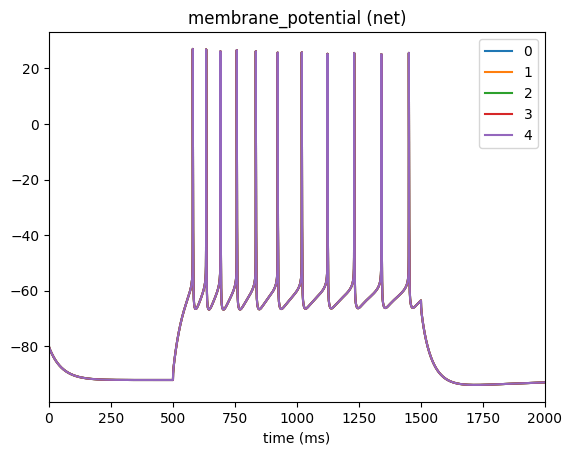

In [11]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.current_clamp.json',  node_ids=range(5), report_name='membrane_potential')

#### Selecting different placement

Besides the `soma`, most morphologically detailed models will also give you options to place a clamp at the `axon`, `dend` (dendriates), `basal` (basal dendrites), or the `apic` (the apical dendrites). However unlike the `soma`, these other sections may be split into hundreds of different **section_index** (aka branches and compartments). If you do not know the specific section index for where you want to place the clamp you can use specify a range (in microns from the soma) of where you want BMTK to place it randomly.

For example if we want to place the current injection at a random location on the apical or basal dendrites that is atleast 500 um away from the soma

```json
"inputs": {
    "current_clamp_apic": {
    "input_type": "current_clamp",
    "module": "IClamp",
    "node_set": {
        "population": "net", 
        "node_id": [0]
    },
    "amp": 0.1000,
    "delay": 500.0,
    "duration": 1000.0,
    "section_name": ["dend", "apic"],
    "section_index": [500.0, 1.0e20]
    }
}
```
* We are trying to find any section that is (500, $\infty$) away from the soma. However python doesn't handle infinity values very well so we just use a distance, 1e20, that we know will cover all feasible segments

<div class="alert alert-block alert-info">
 WARNING: As mentioned before this won't work on point-neurons or neurons with only a soma. Some morphologically detailed models may not have an "apic" section (or other section types too) and a simulation would thus fail if you attempt to insert an injection into such a section.
</div>

In [1]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.current_clamp_apic.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 11:49:01,014 [INFO] Created log file
2024-05-05 11:49:01,122 [INFO] Building cells.
2024-05-05 11:49:02,108 [INFO] Building recurrent connections
2024-05-05 11:49:02,125 [INFO] Running simulation for 2000.000 ms with the time step 0.100 ms
2024-05-05 11:49:02,127 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 11:49:02,128 [INFO] Block save every 5000 steps
2024-05-05 11:49:03,210 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 11:49:04,225 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 11:49:05,562 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 11:49:06,625 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 11:49:06,635 [INFO] Simulation completed in 4.51 seconds 


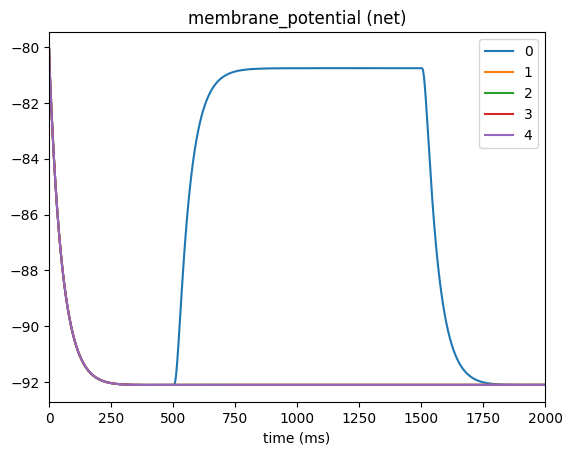

In [2]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.current_clamp_apic.json',  node_ids=range(5), report_name='membrane_potential')

### Adding multiple Clamps

If you need to add multiple current-clamps (whether they overlap in time or not) to your simulation you can easily do it by adding multiple sections to the "inputs" sections:

```json
"inputs": {
    "current_clamp_1": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "node_id": [0]
        },
        "amp": 0.1500,
        "delay": 500.0,
        "section_name": "soma"
    },
    "current_clamp_2": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "node_id": [0]
        },
        "amp": 0.1750,
        "delay": 1500.0,
        "duration": 500.0,
        "section_name": "soma"
    },
    "current_clamp_3": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "node_id": [0]
        },
        "amp": 0.2000,
        "delay": 2500.0,
        "duration": 500.0,
        "section_name": "soma"
    }
}
```

#### As a list

However if you are applying clamps to the same **node_set** and **section** it is also possible to set **amp**, **duration**, and **delay** as a list. The main difference is that we must set the **module** to value `list`.

```json
"inputs": {
    "current_clamp_list": {
        "input_type": "current_clamp",
        "module": "list",
        "node_set": {
            "population": "net", 
            "model_type": "biophysical"
        },
        "amp": [0.1500, 0.1750, 0.2000],
        "delay": [500.0, 1500.0, 2500.0],
        "duration": [500.0, 500.0, 500.0]
        "section_name": "soma"
    }
}
```


## Example: Complex current-clamp waveforms <a class="anchor" id="example-iclamp-waveforms">

In the above example we inserted a current clamp as single or a series of step-currents. However you may want to use another input waveform like a wave or a gradual current which, if needed to be implemented using the above approach, would be mostly unfeasbile. Luckily, BMTK also allows us to save our current function into a csv file which can contain many individual points determining how the current will change at each step of time.

This is done in much the same way as in the example above with two exceptions:
1. The **module** should be set to value `csv`.
2. Instead of specifying the **amp**, **delay**, or **duration**; you specify the **file** path to the csv file.

For example to have a sequences of current clamps in the above example we would add the following to our configuration file:

```json
"inputs": {
    "current_clamp_series": {
        "input_type": "csv",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "model_type": "biophysical"
        },
        "file": "$INPUT_DIR/iclamp_inputs_series.csv",
        "section_name": "soma"
    }
}
```

Where our file has the following format, each row specifying the time **time-stamp**, where 0 represents beginning of simulation, at which the **amp** value is changes

In [1]:
import pandas as pd

pd.read_csv('inputs/iclamp_inputs_series.csv', sep=' ')

,timestamps,amps
0,500.0,0.150
1,1000.0,0.000
2,1500.0,0.175
3,2000.0,0.000
4,2500.0,0.200
5,3000.0,0.000


Also note that unlike with the above example there is no **delay**, thus to turn off current between blocks we must reset amp to 0.0

In [5]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.csv_series.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 12:32:49,833 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-05-05 12:32:49,851 [INFO] Building cells.
2024-05-05 12:32:50,585 [INFO] Building recurrent connections
2024-05-05 12:32:50,609 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-05-05 12:32:50,614 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 12:32:50,615 [INFO] Block save every 5000 steps
2024-05-05 12:32:52,358 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 12:32:54,016 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 12:32:55,620 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 12:32:57,227 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 12:32:58,778 [INFO]     step:25000 t_sim:2500.00 ms
2024-05-05 12:33:00,376 [INFO]     step:30000 t_sim:3000.00 ms
2024-05-05 12:33:00,394 [INFO] Simulation completed in 9.785 seconds 


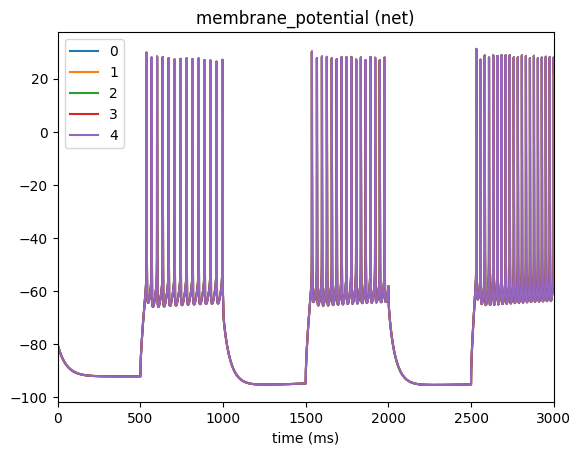

In [6]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.csv_series.json',  node_ids=range(5), report_name='membrane_potential')

For a more complex example, we will use numpy to create current-clamp trace that represents a damped wave. We'll save it to file *inputs/iclamp_damped_wave.csv*

In [9]:
import pandas as pd
import numpy as np

start_time = 0.0
stop_time=3000.0
dt=0.1

times_secs = np.arange(start_time, stop_time, step=dt*200)/1000
amps_na = np.sin(times_secs*3*np.pi)*np.exp(-times_secs)
pd.DataFrame({
    'timestamps': np.round(times_secs*1000, decimals=1),
    'amps': amps_na*.1
}).to_csv('inputs/iclamp_damped_wave.csv', sep=' ', index=False)


Then modify the config as such

```json
"inputs": {
    "current_clamp_wave": {
        "input_type": "csv",
        "module": "IClamp",
        "node_set": {
            "population": "net", 
            "model_type": "biophysical"
        },
        "file": "$INPUT_DIR/iclamp_damped_wave.csv",
        "section_name": "soma"
    }
}
```

Then run the simulation and plot the membrane potential to see that indeed, the cell is acting as we would expect when injecting a damped wave into the soma

In [10]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.csv_wave.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 13:05:33,058 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-05-05 13:05:33,072 [INFO] Building cells.
2024-05-05 13:05:34,069 [INFO] Building recurrent connections
2024-05-05 13:05:34,085 [WARNING] IClampMod: Stimulus of ./inputs/iclamp_damped_wave.csv does not end with a 0.0, attempting to set turn off at time 3000.0.
2024-05-05 13:05:34,093 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-05-05 13:05:34,098 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 13:05:34,099 [INFO] Block save every 5000 steps
2024-05-05 13:05:35,856 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 13:05:37,875 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 13:05:39,645 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 13:05:41,639 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 13:05:43,769 [INFO]     step:25000 t_sim:2500.00 ms
2024-05-05 13:05:45,737 [INFO]     step:30000 t_sim:3000.00 ms
2024-05-05 13

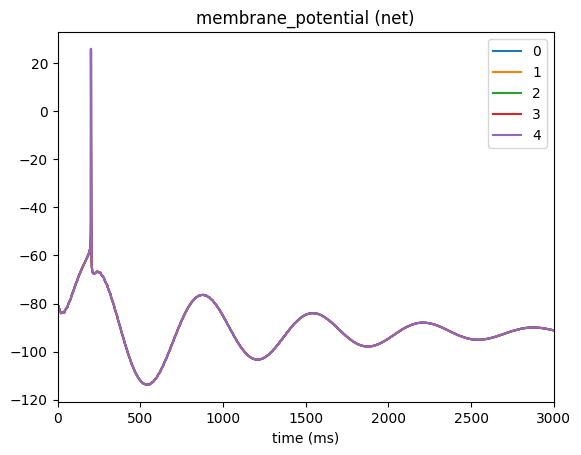

In [11]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.csv_wave.json',  node_ids=range(5), report_name='membrane_potential')

## Example: Voltage Clamps <a class="anchor" id="example-voltage-clamps">

Besides the current clamp, we can use a voltage clamp to set one or more cells to have a constant membrane voltage during some period of the simulation. And like the IClamp we can dynamically insert or remove a voltage clamp during any given simulation by simply editing our SONATA configuration json file. However, note that not all models allow us to insert a voltage clamp - in particular only models with conductance based mechanics allow voltage clamps (so for example we cannot clamp a integrate-and-fire neuron).

In the network built using the file *build_network.voltage_clamp.py* we have a simple network of two cells, with cell #1 synapsing onto cell #2. As we might do with a simple in-vitro experiment we want to clamp only one cell and see the results it has on both cells. And we want to use a simple single-electrode clamp (eg `SEClamp`) which is the simplest way to fix the voltage of one or more cells. To do so we add the following to the SONATA configuration **"inputs**" section:

```json
    "inputs": {
      "se_clamp_1": {
        "input_type": "clamp",
        "module": "SEClamp",
        "node_set": {
            "population": "net", 
            "node_ids": [0]
        },
        "amp": 20.0,
        "duration": 1000.0,
        "delay": 1000.0,
        "section_name": "soma",
        "section_index": 0,
        "section_dist": 0.5
      }
    }
```

* We must set **input_type** to `clamp` and **module** to 'SEClamp` to tell BMTK which type of stimuli that is being added.
* For the **node_set** we make sure to only attach a clamp to cell with `node_id=0`. (eg our source cell only, not the second cell in the network).
* We must specify the onset/**delay** of the clamp (in ms), the **duration** (ms) and the **amp** (mV) at which we want to hold our cell. In this case we will set the cell such that between times 1000 to 2000 ms it will be clamped to a membrane voltage of 20.0 mV.
* As with current-clamp we have options **section_name**, **section_index** and **section_dist** to determine where to place the clamp within the cell. If not specified BMTK will place it by default in the center of the soma.
* We can specifcy the **resistance** in nOhms - by default it will be set to 0.0.


<div class="alert alert-block alert-info">
⚠️ WARNING: Currently SEClamp can only handle simple single square-wave block. It does not support advance features like specified in the IClamp.
</div>

In [1]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.voltage_clamp.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-06-24 17:25:45,034 [INFO] Created log file
2024-06-24 17:25:45,088 [INFO] Building cells.
2024-06-24 17:25:45,224 [INFO] Building recurrent connections
2024-06-24 17:25:45,235 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-06-24 17:25:45,236 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-06-24 17:25:45,237 [INFO] Block save every 5000 steps
2024-06-24 17:25:45,618 [INFO]     step:5000 t_sim:500.00 ms
2024-06-24 17:25:45,980 [INFO]     step:10000 t_sim:1000.00 ms
2024-06-24 17:25:46,394 [INFO]     step:15000 t_sim:1500.00 ms
2024-06-24 17:25:46,824 [INFO]     step:20000 t_sim:2000.00 ms
2024-06-24 17:25:47,233 [INFO]     step:25000 t_sim:2500.00 ms
2024-06-24 17:25:47,617 [INFO]     step:30000 t_sim:3000.00 ms
2024-06-24 17:25:47,631 [INFO] Simulation completed in 2.396 seconds 


Now we can plot the membrane potential for the cell with the attached clamp (node-id 0) as-well-as the downstream cell in our network (node-id 1)

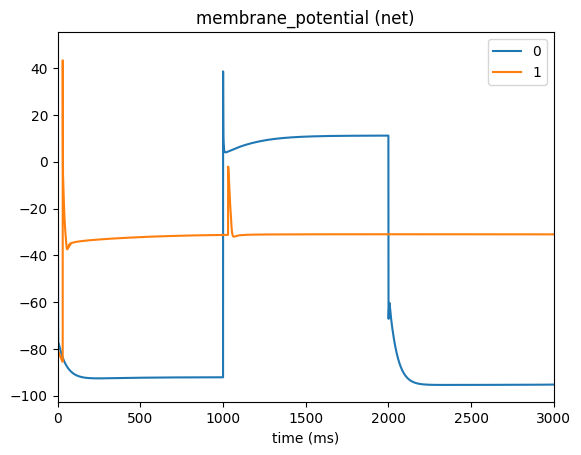

In [4]:
from bmtk.analyzer.compartment import plot_traces

_ = plot_traces(config_file='config.voltage_clamp.json', report_name='membrane_potential', population='net', node_ids=[0, 1])

## Example: Using sweep data from the Allen Cell-Types Database <a class="anchor" id="example-cell-types">

When creating the [Cell-Type Database at the Allen Insitute](https://celltypes.brain-map.org/data), a wide range of clamping stimuli was used in the process of optimizing the parameters for the thousands of human and mouse cell models. BMTK allows the option to download and import these stimuli directly into single and multi-cell simulations (for both BioNet and PointNet). Thus allowing users to apply the same conditions for their own models. Or as just a way to use much more advanced and realistic current-clamping stimuli that would be difficult to rebuild from scratch.

### Step 1: Downloading the data

First step is determine which experimental conditions we want to replicate and which stimlus types to use. Different cells were in the Allen Cell Types Database were optimized and tested against different types current clamps. For example if we look at the electrophysiology page for [cell 488683425](https://celltypes.brain-map.org/experiment/electrophysiology/488683425) we can see we have stimulus types including `Long square`, `Noise`, `Ramp`, `Short Square` and `Square`. And for each types there are different *sweeps* where amplitudes and times were varied between trials:

<br>
<div>
  <img src="../images/cell_types_screen.png" width="1000" align="center" style="margin-left:5px"/>    
</div>
<br clear="left">

If you click on the "`Download Data`" file it will download an ecephy.nwb file containing all the *sweep* available for said experiment. You just need to put it in a directory that can be accessed by BMTK. If you need a more programatically way to download multiple ecephy files you can use the AllenSDK, and BMTK also includes helper functions to download the data. You can run the following in a command-line:
```bash
$ python -m bmtk.utils.cell_types_db download_ephys_data --specimen-id=488683425 --download-dir=ecephys_inputs
```

Or through the notebook

In [1]:
from bmtk.utils.cell_types_db import download_ephys_data

download_ephys_data(
    specimen_id=488683425,
    download_dir='ephys_inputs'
)

Due to the size of the files and available internet speeds it may take some time to fully donwnload the nwb file(s). But when it does it will save the file into the local *ephys_inputs/* directory.

### (Optional) Step 2: Downloading cell model data

The downloaded ephys data can be used with any cell-type (even cells that are not from the Allen Cell-Types Database). However for testing and replication purposes you may want to run the downloaded ephys data on the original cell. If you click on `Select neuronal model` button on the page it will give you an option to download a possible GLIF Model (which can be ran using PointNet) or a Biophysical (ran using BioNet) model. This will download a zip file containing the *fit_parameters.json* which you can use as the **dynamics_params** in you SONATA network. Also for Biophysical models it will contain the file *reconstruction.swc* which is the **morphology** swc file for the specific cell. You can move these file(s) into their appropiate *components/* directory and rebuild/modify the SONATA network file so that **dynamics_params** and **morphology** points to the correct paths.

Alternatively you can use BMTK to download, move and rename the files for you. In the command line you can run:
```bash
$ python -m bmtk.utils.cell_types_db download_model --specimen-id=488683425 --model-dir="components" --model-type="Biophysical - all active"
```

or in python
```python
model_dir = download_model(
    specimen_id=488683425,
    model_dir='components',
    model_type='Biophysical - all active'
)
```


### Step 3: Set the configuration

To use the downloaded ephys.nwb file we just need to create an "inputs sections with **module** set to `iclamp` and **input_type** set to `allen`. Use the **file** option to point to the path of our downloaded nwb file. And finally we must select our **sweep** number. In this case we'll use sweep #35 which is just a 1 second long-square current.

```json
"inputs": {
    "current_clamp_allen": {
        "module": "IClamp",
        "input_type": "allen",
        "node_set": "all",
        "file": "${INPUT_DIR}/488683423_ephys.nwb",
        "sweep_id": "35"
    }
}
```


In [3]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.cell_types.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-05-05 14:54:45,142 [INFO] Created log file
2024-05-05 14:54:45,243 [INFO] Building cells.
2024-05-05 14:54:45,490 [INFO] Building recurrent connections
2024-05-05 14:54:45,857 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-05-05 14:54:45,858 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-05-05 14:54:45,859 [INFO] Block save every 5000 steps
2024-05-05 14:54:53,078 [INFO]     step:5000 t_sim:500.00 ms
2024-05-05 14:55:00,473 [INFO]     step:10000 t_sim:1000.00 ms
2024-05-05 14:55:07,069 [INFO]     step:15000 t_sim:1500.00 ms
2024-05-05 14:55:13,562 [INFO]     step:20000 t_sim:2000.00 ms
2024-05-05 14:55:20,164 [INFO]     step:25000 t_sim:2500.00 ms
2024-05-05 14:55:26,899 [INFO]     step:30000 t_sim:3000.00 ms
2024-05-05 14:55:26,917 [INFO] Simulation completed in 41.06 seconds 


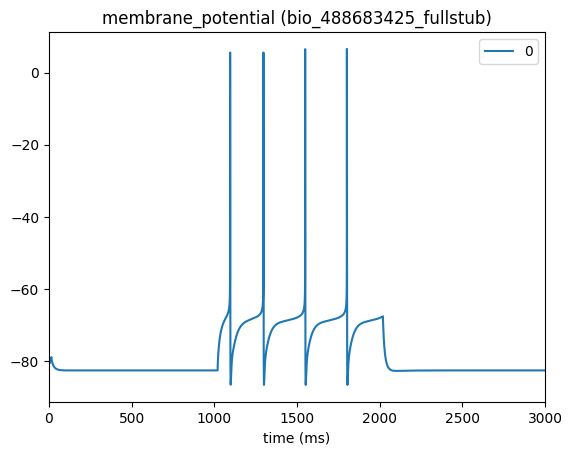

In [4]:
from bmtk.analyzer.compartment import plot_traces
_ = plot_traces(config_file='config.cell_types.json',  node_ids=[0], report_name='membrane_potential')

## Example: Extracellular Stimulation <a class="anchor" id="example-xstim">

<div class="alert alert-block alert-info">
⚠️ NOTE: This feature will only work in BioNet using morphologically detailed cells.
</div>

The *BioNet* simulator has optional input stimulus an electric field impulse, thus allowing you to simulat of deep brain stimulation. One or more stimulating electrodes (or a mesh) can be readily inserted and removed into most networks and used along side other stimuli through simple changes to the SONATA config. However, take note that this can only be applied to cells with a biophysical conductances, such as morphologically detailed "biophysical" cells or even simple single-compartment "soma" cells, but won't work for integrate-and-fire type neurons.

When extracellular stimulation(s) are inserted into a simulation, the effect the generated filed has on the extracellular membrane of each cell compartment will depend on the geometric relationship between the cell and the electrode(s). Thus it is important that we specify the **x**, **y**, **z** attributes for each cell, plus make sure the cell is rotated properly (as specified by attributes **rotation_angle_x**, **rotation_angle_y**, **rotation_angle_z**). Once we have such a network (see *build_network.xstim.py*) we can go ahead and insert an extracellular stimulation into a simulation by adding to the **"inputs"** section of the SONATA config like such:

``` json
  "inputs": {
    "Extracellular_Stim": {
      "module": "xstim",
      "input_type": "lfp",
      "node_set": {
        "model_type": "biophysical"
      },
      "positions_file": "components/stimulations/xstim_coords.csv",
      "resistance": 300.0,
      "waveform": {
        "shape": "sin",
        "del": 1000.0,
        "amp": 0.100,
        "dur": 2000.0,
        "freq": 8.0,
        "phase": 0.0
      }
    }
  }
```
* You must set **module** to "xstim" and **input_type** to "lfp" to signal to bmtk the mode of stimulus to apply
* The **node_set** is used to filter out which subset of cells in the network to apply the xstim. In this case we want to apply it to all "biophysical" type cells (in this example all are cells are "biophysical", but in mixed networks it's important to keep track of which cells are biophysical and which are not - otherwise BMTK can fail when applying this stimulus to "point-neuron" type cells).
* Set the extracellular resistance between the electrode(s) and the cells.
* The **waveform** is set to generate a sin-wave shaped stimuli, starting at 1000 ms (**del**) that will run for 2000 ms (**dur**) with a maximum amplitude of .100 nA (**amp**). 
* Lastly the **positions_file** is used to specify the coordinates of the electrodes (or if using a mesh grid also the rotation). It should be a space-separated file with each row being the location of a different electrode. In our case we are only applying a single electrode


In [1]:
import pandas as pd

pd.read_csv('components/stimulations/xstim_coords.csv', sep=' ')

,ip,pos_x,pos_y,pos_z,rotation_x,rotation_y,rotation_z
0,0,6.18034,0.0,19.02113,0.0,0.0,0.0


Now we can run the simulation as normal and show the varying results in terms of changes to cell membrane potentials

In [2]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.xstim_sin.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

2024-06-24 14:27:32,061 [INFO] Created log file
2024-06-24 14:27:32,109 [INFO] Building cells.
2024-06-24 14:27:32,303 [INFO] Building recurrent connections
2024-06-24 14:27:32,480 [INFO] Running simulation for 4000.000 ms with the time step 0.100 ms
2024-06-24 14:27:32,481 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-06-24 14:27:32,482 [INFO] Block save every 10000 steps
2024-06-24 14:27:40,453 [INFO]     step:10000 t_sim:1000.00 ms
2024-06-24 14:27:48,758 [INFO]     step:20000 t_sim:2000.00 ms
2024-06-24 14:27:56,865 [INFO]     step:30000 t_sim:3000.00 ms
2024-06-24 14:28:04,825 [INFO]     step:40000 t_sim:4000.00 ms
2024-06-24 14:28:04,834 [INFO] Simulation completed in 32.35 seconds 


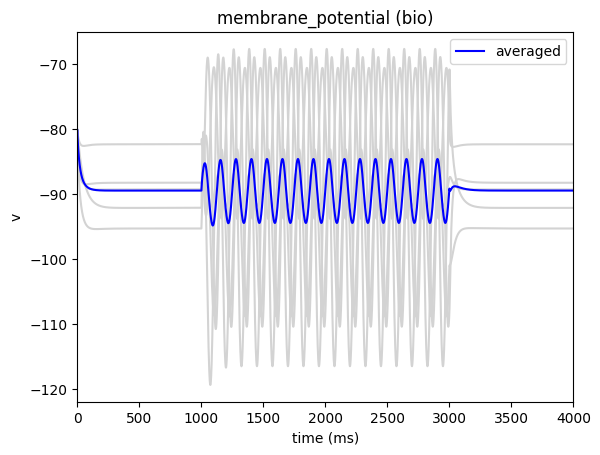

In [4]:
from bmtk.analyzer.compartment import plot_traces

_ = plot_traces(config_file='config.xstim_sin.json', report_name='membrane_potential', population='bio')

### More advanced wave-forms

In the above example we set it so the stimulus will generate a sin-wave at the electrode site. BMTK has a number of built-in shapes available, including a sin-wave a a direct-current (**waveform**: "dc")

```json
  "inputs": {
    "Extracellular_Stim": {
      "module": "xstim",
      "input_type": "lfp",
      "node_set": {
        "model_type": "biophysical"
      },
      "positions_file": "$STIM_DIR/xstim_coords.csv",
      "resistance": 300.0,
      "waveform": {
        "shape": "dc",
        "del": 1000.0,
        "amp": 0.400,
        "dur": 1000.0
      }
    }
  },
```

2024-06-24 14:33:33,694 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-06-24 14:33:33,718 [INFO] Building cells.
2024-06-24 14:33:33,993 [INFO] Building recurrent connections
2024-06-24 14:33:34,190 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-06-24 14:33:34,191 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-06-24 14:33:34,193 [INFO] Block save every 10000 steps
2024-06-24 14:33:49,082 [INFO]     step:10000 t_sim:1000.00 ms
2024-06-24 14:34:03,980 [INFO]     step:20000 t_sim:2000.00 ms
2024-06-24 14:34:19,004 [INFO]     step:30000 t_sim:3000.00 ms
2024-06-24 14:34:19,019 [INFO] Simulation completed in 44.83 seconds 


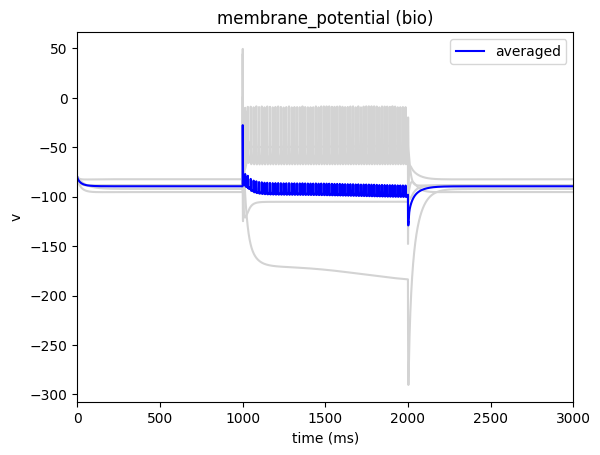

In [8]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.xstim_dc.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

_ = plot_traces(config_file='config.xstim_dc.json', report_name='membrane_potential', population='bio')

Or alternatively, instead of having BMTK try to generate a shape for us, we can create the stimlus waveform ourselves. To do so we just need to create a space-separated csv file with columns **time** (ms) and **amplitude** (nA) and set the **waveform** attribute in our csv file to the path of the file.

For example, the following lines of code will generate a slow ramping csv file that will go from -0.100 nA to 0.500 nA within a 3 second window, and save it under *./inputs/ramping_xstim.csv*

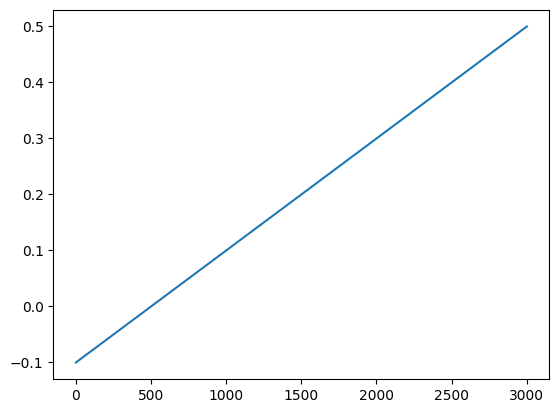

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

time = np.linspace(0.0, 3000.0, 1000)
amplitude = time*0.0002-.100

pd.DataFrame({
    'time': time,
    'amplitude': amplitude
}).to_csv('inputs/ramping_xstim.csv', sep=' ', index=False)
plt.plot(time, amplitude)

Then in our configuration file we just need to change the **waveform** attribute to point to the location of our customized file

```json
  "inputs": {
    "Extracellular_Stim": {
      "module": "xstim",
      "input_type": "lfp",
      "node_set": {
        "model_type": "biophysical"
      },
      "positions_file": "$STIM_DIR/xstim_coords.csv",
      "resistance": 300.0,
      "waveform": "inputs/ramping_xstim.csv"
    }
  }
```

And run it like before

2024-06-24 14:42:31,518 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2024-06-24 14:42:31,541 [INFO] Building cells.
2024-06-24 14:42:31,826 [INFO] Building recurrent connections
2024-06-24 14:42:32,029 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2024-06-24 14:42:32,030 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2024-06-24 14:42:32,031 [INFO] Block save every 10000 steps
2024-06-24 14:42:55,386 [INFO]     step:10000 t_sim:1000.00 ms
2024-06-24 14:43:21,217 [INFO]     step:20000 t_sim:2000.00 ms
2024-06-24 14:43:50,595 [INFO]     step:30000 t_sim:3000.00 ms
2024-06-24 14:43:50,609 [INFO] Simulation completed in 78.58 seconds 


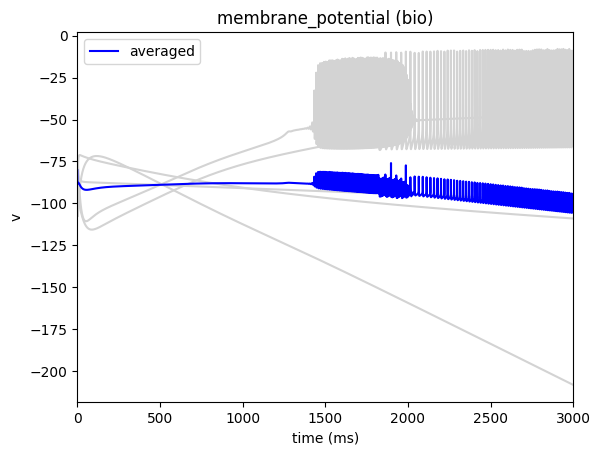

In [15]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json('config.xstim_custom.json')
conf.build_env()

graph = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=graph)
sim.run()

_ = plot_traces(config_file='config.xstim_custom.json', report_name='membrane_potential', population='bio')